#  Evaluating Object Detections with FiftyOne
https://voxel51.com/docs/fiftyone/tutorials/evaluate_detections.html

This walkthrough demonstrates how to use FiftyOne to perform hands-on evaluation of your detection model.

It covers the following concepts:

- Loading a dataset with ground truth labels [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- [Adding model predictions](https://voxel51.com/docs/fiftyone/recipes/adding_detections.html) to your dataset
- [Evaluating your model](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections) using FiftyOne's evaluation API
- Viewing the best and worst performing samples in your dataset

**So, what's the takeaway?**

Aggregate measures of performance like mAP don't give you the full picture of your detection model. In practice, the limiting factor on your model's performance is often data quality issues that you need to **see** to address. FiftyOne is designed to make it easy to do just that.

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model's performance
- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

## Setup

If you haven't already, install FiftyOne:

In [ ]:
#!pip install fiftyone
!pip install fiftyone --no-binary fiftyone,voxel51-eta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get data and files

# # Disney 3D Human Test (with 0.7 threshold and additional annotations like "duplicate_detection" and "false_positive")
# !unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_test.zip > /dev/null
# !cp /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/FiftyOne/disney_3D_human_test_COCO_gt_face.json gt.json > /dev/null # ground-truth bbox # ResNet101
# !cp /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/FiftyOne/predictions.json pred.json > /dev/null # ResNet101

# # Disney 3D Human Test (with 0.05 (default) threshold)
# # Files were created with "Inference_From_Saved_Model_Detectron2"
# !unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_test.zip > /dev/null
# !unzip /content/drive/MyDrive/machine_learning/Results/disney3Dhumantest_detection_inference_resnet101_threshold0.05.zip > /dev/null
# !cp /content/out/disney_test_set_coco_format.json gt.json > /dev/null # ground-truth bbox # ResNet101
# !cp /content/out/coco_instances_results.json pred.json > /dev/null # predicted bbox # ResNet101

# # Dettrain
# !unzip /content/drive/MyDrive/machine_learning/datasets/CartoonDataset.zip -d datasets > /dev/null
# !cp /content/drive/MyDrive/machine_learning/Analysis/Dettrain/FiftyOne/ResNet101/cartoon_val_coco_format.json gt.json > /dev/null # ground-truth bbox # ResNet101
# !unzip /content/drive/MyDrive/machine_learning/Models/Detection/resnet101.zip > /dev/null
# !cp /content/output/coco_eval/coco_instances_results.json pred.json > /dev/null # predicted bbox # ResNet101

# # Detection Test
!unzip /content/drive/MyDrive/machine_learning/datasets/Detection_Test.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/Analysis/Detection_Test/ResNet101.zip > /dev/null
!cp /content/out/Detection_Test_coco_format_for_51.json gt.json > /dev/null # gt bbox
!cp /content/out/coco_instances_results_for_51.json pred.json > /dev/null # predicted bbox

# If have time can analyse ResNet50

If you run into a `cv2` error when importing FiftyOne later on, it is an issue with OpenCV in Colab environments. [Follow these instructions to resolve it.](https://github.com/voxel51/fiftyone/issues/1494#issuecomment-1003148448)

In [ ]:
# Upload own COCO metrics: https://voxel51.com/docs/fiftyone/integrations/coco.html#coco
import os
# !pip install opencv-python-headless==4.5.4.60 # if there is a cv2 error
import fiftyone as fo
import fiftyone.zoo as foz

IMAGES_DIR = os.path.dirname("/content/Detection_Test")
# IMAGES_DIR = os.path.dirname("/content/disney_3D_human_test")
# IMAGES_DIR = os.path.dirname("/content/datasets/CartoonDataset/val")

NumExpr defaulting to 4 threads.
Migrating database to v0.16.5


In [ ]:
# For some reason the Dettrain preds and images are not aligned
# Quick fix is to change the label "image_id":0 to "image_id":5000 in gt.json

In [ ]:
# Load COCO formatted dataset
!python -m json.tool gt.json

In [ ]:
LABELS_PATH="/content/gt.json"

coco_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=IMAGES_DIR,
    labels_path=LABELS_PATH,
    include_id=True,
    #label_field="", #seems to break the code if uncommented
)

# Verify that the class list for our dataset was imported
print(coco_dataset.default_classes)

print(coco_dataset)

 100% |█████████████████| 650/650 [2.1s elapsed, 0s remaining, 305.1 samples/s]      
['Face']
Name:        2022.08.02.11.34.57
Media type:  image
Num samples: 650
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    coco_id:    fiftyone.core.fields.IntField


Note that the ground truth detections are stored in the `ground_truth` field of the samples. In my case, they are under `detections`

Before we go further, let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use the GUI to explore the dataset visually:

In [ ]:
# session = fo.launch_app(coco_dataset)

## Add predictions to dataset

Now let's analyze some predictions.

In [ ]:
# Upload the predictions made by my model
import json
with open("pred.json") as f:
  predictions = json.load(f)

print(f"Number of predictions: {len(predictions)}")
#predictions = list(pred_dict.values())[0]

Number of predictions: 6359


In [ ]:
import fiftyone.utils.coco as fouc
# Add COCO predictions to `predictions` field of dataset

# # disney_3D_human_test predictions with threshold 0.05 have class "Face"
# if "disney" in IMAGES_DIR:
#   # Disney_3D_Human_Test
#   classes = ["ignore","face"] # Disney_3D_human_test: category_id = 1, so need non-existent 0 class
# elif "CartoonDataset" in IMAGES_DIR:
#   # Dettrain
#   classes = ["Face"]
# else:
#   print("Unknown dataset!")

classes = ["Face"]
fouc.add_coco_labels(coco_dataset, "predictions", predictions, classes=classes)

# Verify that predictions were added to dataset images
print(coco_dataset.count("predictions"))

650


In [ ]:
#coco_dataset.first()

Let's visualize the predictions that we added:

In [ ]:
# How to try to prevent the views from reloading constantly 
# when multiple are rendered for the same session: https://voxel51.com/docs/fiftyone/environments/index.html#notebooks
session = fo.launch_app(coco_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


In [ ]:
session.show()

## Remove bbox that are likely duplicate detections

In [ ]:
# Example prediction
sample = coco_dataset.first()
preds = sample.predictions.detections[0]
print(preds)

In [ ]:
# If want to remove duplicates AFTER thresholding, run this cell first
new_predictions = [x for x in predictions if x["score"] > 0.495] #695
print(f"Number of predictions remaining: {len(new_predictions)}")

# Update predictions
predictions = new_predictions

Number of predictions remaining: 1854


In [ ]:
# Get image ids
ids = [x["image_id"] for x in predictions]
unique_ids = list(set(ids))
print(f"Processing {len(unique_ids)} images...")

Processing 648 images...


In [ ]:
# Helper functions
def get_matches(id, predictions):
  matches = [x for x in predictions if x["image_id"] == id]
  return matches

def lowest_conf_pred(pair):
  if pair[1]["score"] <= pair[0]["score"]:
    return pair[1]["image_id"], pair[1]["bbox"][0] # no id value to return :(
  else:
    return pair[0]["image_id"], pair[0]["bbox"][0]

In [ ]:
def check_intersection(pairs):
  # Store prediction ids that are duplicate detections in image
  preds_to_remove = []

  for pair in pairs:
    #print(pair)

    # Calculate area of each bbox
    a_area = pair[0]["bbox"][2] * pair[0]["bbox"][3]
    b_area = pair[1]["bbox"][2] * pair[1]["bbox"][3]

    # Calculate intersection overlap
    # Bounding box format is [top-left-x, top-left-y, width, height]
    a_x1 = pair[0]["bbox"][0]
    a_y1 = pair[0]["bbox"][1]
    a_x2 = pair[0]["bbox"][0] + pair[0]["bbox"][2]
    a_y2 = pair[0]["bbox"][1] + pair[0]["bbox"][3]

    b_x1 = pair[1]["bbox"][0]
    b_y1 = pair[1]["bbox"][1]
    b_x2 = pair[1]["bbox"][0] + pair[1]["bbox"][2]
    b_y2 = pair[1]["bbox"][1] + pair[1]["bbox"][3]

    dx = min(a_x2, b_x2) - max(a_x1, b_x1)
    dy = min(a_y2, b_y2) - max(a_y1, b_y1)
    if (dx>=0) and (dy>=0):
      intersection = dx*dy
      #print(f"Intersection area: {intersection}")

      # Is the intersection greater than 50% of eitehr bbox area?
      a_overlap = intersection / a_area
      b_overlap = intersection / b_area
      #print(f"Overlap percentage: {a_overlap}, {b_overlap}")
      if a_overlap >= 0.5 or b_overlap >= 0.5:
        image_id, bbox_x1 = lowest_conf_pred(pair)
        markers = (image_id, bbox_x1)
        preds_to_remove.append(markers)
        #print(f"Pred to remove: {markers}")
    else:
      #print("No intersection")
      continue
    
  return(preds_to_remove)

In [ ]:
# Remove predictions with intersection >= threshold (0.5)
import itertools
complete_list = []

for id in unique_ids:
  # Get all predictions from 1 image
  matches = get_matches(id, predictions)

  # Sort the boxes from highest to lowest conf score
  matches.sort(key=lambda x: x["score"], reverse=True)
  #print(matches)

  # Create list with all unique pair-wise permutations
  pair_order_list = itertools.combinations(matches,2)
  pairs = list(pair_order_list)
  num_pairs = len(pairs)
  #print(f"Number of pairs for image_id {id}: {num_pairs}")

  # Skip if only one prediction in image
  if num_pairs == 0:
    #print(f"Skipping image_id {id} because no pairs")
    continue

  # Get predictions ids that are duplicate detections
  preds_to_remove = check_intersection(pairs)
  if len(preds_to_remove) > 0:
    # Add ids to remove
    complete_list.extend(preds_to_remove)

unique_complete_list = list(set(complete_list))
#print(f"List of predictions to remove: {unique_complete_list}")
print(f"Removing {len(unique_complete_list)} predictions...")

Removing 228 predictions...


In [ ]:
# Update predictions dict
new_predictions = []
for x in predictions:
  if (x["image_id"], x["bbox"][0]) not in unique_complete_list:
    new_predictions.append(x)
print(f"Number of predictions remaining: {len(new_predictions)}")

Number of predictions remaining: 1626


In [ ]:
predictions = new_predictions
# Now re-run the cells in the previous section that add predictions to coco_dataset

## Analyzing detections

### Selecting samples of interest

You can select images in the App by clicking on the checkbox when hovering over an image. Then, you can create a view that contains only those samples by clicking the orange checkmark with the number of selected samples in the top left corner of the sample grid and clicking `Only show selected samples`.

### Confidence thresholding
From the App instance above, it looks like our detector is generating some spurious low-quality detections. Let's use the App to interactively filter the predictions by `confidence` to identify a reasonable confidence threshold for our model. Click on "predictions" and set drag the caret to a higher confidence threshold

FiftyOne also provides the ability to [write expressions](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) that match, filter, and sort detections based on their attributes. See [using DatasetViews](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) for full details.

For example, we can programmatically generate a view that contains only detections whose `confidence` is at least `0.70` as follows:

In [ ]:
from fiftyone import ViewField as F

# Create views at different confidence thresholds
high_conf_view = coco_dataset.filter_labels("predictions", F("confidence") >= 0.70)

complete_view = coco_dataset.filter_labels("predictions", F("confidence") >= 0.05)
conf_view_50 = coco_dataset.filter_labels("predictions", F("confidence") >= 0.50)
conf_view_60 = coco_dataset.filter_labels("predictions", F("confidence") >= 0.60)
conf_view_70 = coco_dataset.filter_labels("predictions", F("confidence") >= 0.70)
conf_view_80 = coco_dataset.filter_labels("predictions", F("confidence") >= 0.80)
conf_view_90 = coco_dataset.filter_labels("predictions", F("confidence") >= 0.90)

In [ ]:
# Print some information about the view
print(high_conf_view)
print(complete_view)
print(conf_view_50)
print(conf_view_60)
print(conf_view_70)
print(conf_view_80)
print(conf_view_90)

In [ ]:
# Print a prediction from the view to verify that its confidence is >= 0.70
sample = high_conf_view.first()
print(sample.predictions.detections[0])

Now let's load our view in the App to view the predictions that we programmatically selected:

In [ ]:
# Load high confidence view in the App
session.view = high_conf_view
session.show()

### Viewing object patches

There are multiple situations where it can be useful to visualize each object separately. For example, if a sample contains dozens of objects overlapping one another or if you want to look specifically for instances of a class of objects.

In any case, the FiftyOne App provides a [patches view button](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-object-patches) that allows you to take any `Detections` field in your dataset and visualize each object as an individual patch in the image grid. 

## Evaluate detections

Now that we have samples with ground truth and predicted objects, let's use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) that contains a collection of methods for performing evaluation of model predictions. Since we're working with object detections here, we'll use [detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections).

### Running evaluation

We can run evaluation on our samples via [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). Note that this method is available on both the `Dataset` and `DatasetView` classes, which means that we can run evaluation on our `high_conf_view` to assess the quality of only the high confidence predictions in our dataset.

By default, this method will use the [COCO evaluation protocol](https://cocodataset.org/#detection-eval), plus some extra goodies that we will use later.

In [ ]:
# Evaluate the predictions in the `predictions` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_oi",
    method="open-images", # default is "coco", "open-images" shows AP rather than mAP
    # compute_mAP=True, # only needed for coco
)

### Aggregate results

The `results` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let's print a classification report for the top-10 most common classes in the dataset:

In [ ]:
# Get the 10 most common classes in the dataset
counts = coco_dataset.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

              precision    recall  f1-score   support

        Face       0.66      0.82      0.73      1377

   micro avg       0.66      0.82      0.73      1377
   macro avg       0.66      0.82      0.73      1377
weighted avg       0.66      0.82      0.73      1377



We can also compute the mean average-precision (mAP) of our detector:

In [ ]:
print(results.mAP())

0.7727207571490501


Since [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections) uses the official [COCO evaluation protocol](https://cocodataset.org/#detection-eval), this mAP value will match what `pycocotools` would report.

We can also view some precision-recall (PR) curves for specific classes of our model:

In [ ]:
plot = results.plot_pr_curves(classes=["Face"]) # "Face" for Dettrain, "face" for disney_3D_human_test
plot.show()

In [ ]:
plot.freeze()  # replaces interactive plot with static image

In [ ]:
# Generate a confusion matrix for the specified classes
plot = results.plot_confusion_matrix(classes=["Face"])
plot.show()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1796: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



### Aggregate results (AP50)

In [ ]:
# Get the 10 most common classes in the dataset
counts = coco_dataset.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

In [ ]:
results_all = complete_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_all_oi",
    method="open-images", # default is "coco"
)

results_50 = conf_view_50.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_50_oi",
    method="open-images", # default is "coco"
)

results_60 = conf_view_60.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_60_oi",
    method="open-images", # default is "coco"
)

results_70 = conf_view_70.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_70_oi",
    method="open-images", # default is "coco"
)

results_80 = conf_view_80.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_80_oi",
    method="open-images", # default is "coco"
)

results_90 = conf_view_90.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_90_oi",
    method="open-images", # default is "coco"
)

Evaluating detections...
 100% |█████████████████| 648/648 [8.6s elapsed, 0s remaining, 86.9 samples/s]      
Evaluating detections...
 100% |█████████████████| 648/648 [9.0s elapsed, 0s remaining, 80.4 samples/s]      
Evaluating detections...
 100% |█████████████████| 646/646 [8.9s elapsed, 0s remaining, 75.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 641/641 [9.2s elapsed, 0s remaining, 79.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 637/637 [9.0s elapsed, 0s remaining, 77.2 samples/s]      
Evaluating detections...
 100% |█████████████████| 621/621 [8.7s elapsed, 0s remaining, 79.3 samples/s]      


In [ ]:
results_all.print_report(classes=classes_top10)
print(results_all.mAP())

results_50.print_report(classes=classes_top10)
print(results_50.mAP())

results_60.print_report(classes=classes_top10)
print(results_60.mAP())

results_70.print_report(classes=classes_top10)
print(results_70.mAP())

results_80.print_report(classes=classes_top10)
print(results_80.mAP())

results_90.print_report(classes=classes_top10)
print(results_90.mAP())

              precision    recall  f1-score   support

        Face       0.69      0.81      0.75      1386

   micro avg       0.69      0.81      0.75      1386
   macro avg       0.69      0.81      0.75      1386
weighted avg       0.69      0.81      0.75      1386

0.7737787290658212
              precision    recall  f1-score   support

        Face       0.69      0.81      0.75      1386

   micro avg       0.69      0.81      0.75      1386
   macro avg       0.69      0.81      0.75      1386
weighted avg       0.69      0.81      0.75      1386

0.7727774701381536
              precision    recall  f1-score   support

        Face       0.73      0.80      0.76      1384

   micro avg       0.73      0.80      0.76      1384
   macro avg       0.73      0.80      0.76      1384
weighted avg       0.73      0.80      0.76      1384

0.7671835133693541
              precision    recall  f1-score   support

        Face       0.77      0.79      0.78      1379

   micro avg  

#### Plots

In [ ]:
plot = results_all.plot_pr_curves(classes=["Face"]) # "face" for disney_3D_human_test with threshold 0.05, "Face" for others
plot = results_50.plot_pr_curves(classes=["Face"], figure=plot)
plot = results_60.plot_pr_curves(classes=["Face"], figure=plot)
plot = results_70.plot_pr_curves(classes=["Face"], figure=plot)
plot = results_80.plot_pr_curves(classes=["Face"], figure=plot)
plot = results_90.plot_pr_curves(classes=["Face"], figure=plot)
plot.data[0].line.color = "black"
plot.data[1].line.color = "red"
plot.data[2].line.color = "green"
plot.data[3].line.color = "blue"
plot.data[4].line.color = "purple"
plot.data[5].line.color = "magenta"
plot.update_layout(showlegend=True)
plot.show()

In [ ]:
# Generate a confusion matrix for the specified classes
# plot = results_all.plot_confusion_matrix(classes=["Face"])
# plot = results_50.plot_confusion_matrix(classes=["Face"])
plot = results_60.plot_confusion_matrix(classes=["Face"])
# plot = results_70.plot_confusion_matrix(classes=["Face"])
# plot = results_80.plot_confusion_matrix(classes=["Face"])
# plot = results_90.plot_confusion_matrix(classes=["Face"])
plot.show()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1796: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



In [ ]:
# ### Observations
# Can make the model more precise by increasing the threshold. This inevitably causes the recall to lower a bit.
# Only mechanism to improve recall is to relax threshold.
# Some FPs are actually duplicate detections, remove them via intersection heuristic to improve precision. Note that the model indeed becomes more precise.
# Disney annotations show that alomst all FPs are duplicate detections; not very controlled experiment, but good indication.
# (Is it better to do intersection heuristic before or after thresholding?)
# Some FNs are actually FPs because the bounding box is too big. Nothing can be done to address this, just trust that the recall is better than results suggest, especially after intersection heuristic.
# The intersection heuristic probably removes some lower confidence predictions that were marked as TP, the remaing prediction was probably marked are FP.
# (Do the disney annotations give insights to support my above claim that many FNs are FPs?)

### Sample-level analysis

The evaluation routine also populated some new fields on our dataset that contain helpful information that we can use to evaluate our predictions at the sample-level.

In particular, each sample now contains new fields:

- `eval_tp`: the number of true positive (TP) predictions in the sample
- `eval_fp`: the number of false positive (FP) predictions in the sample
- `eval_fn`: the number of false negative (FN) predictions in the sample

In [ ]:
# Our dataset's schema now contains `eval_*` fields
print(coco_dataset)

Name:        2022.07.19.12.03.01
Media type:  image
Num samples: 650
Persistent:  False
Tags:        []
Sample fields:
    id:          fiftyone.core.fields.ObjectIdField
    filepath:    fiftyone.core.fields.StringField
    tags:        fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    coco_id:     fiftyone.core.fields.IntField
    predictions: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_oi_tp:  fiftyone.core.fields.IntField
    eval_oi_fp:  fiftyone.core.fields.IntField
    eval_oi_fn:  fiftyone.core.fields.IntField


The individual predicted and ground truth objects also have fields populated on them describing the results of the matching process:

- `eval`: whether the object is a TP/FP/FN
- `eval_id`: the ID of the matching ground truth/predicted object, if any
- `eval_iou`: the IoU between the matching objects, if any

In [ ]:
# Our detections have helpful evaluation data on them
sample = high_conf_view.first()
print(sample.predictions.detections[0])

<Detection: {
    'id': '62bbfd628d0abcbcf915ee66',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Face',
    'bounding_box': BaseList([
        0.20541911125183104,
        0.46971537272135416,
        0.19298985004425048,
        0.23460241953531902,
    ]),
    'mask': None,
    'confidence': 0.9967994689941406,
    'index': None,
    'eval_all_oi_iou': 0.6859649511,
    'eval_all_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_all_oi': 'tp',
    'eval_50_oi_iou': 0.6859649511,
    'eval_50_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_50_oi': 'tp',
    'eval_60_oi_iou': 0.6859649511,
    'eval_60_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_60_oi': 'tp',
    'eval_70_oi_iou': 0.6859649511,
    'eval_70_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_70_oi': 'tp',
    'eval_80_oi_iou': 0.6859649511,
    'eval_80_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_80_oi': 'tp',
    'eval_90_oi_iou': 0.6859649511,
    'eval_90_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'e

These extra fields were added because we provided the ``eval_key`` parameter to [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). If we had omitted this parameter, then no information would have been recorded on our samples.

Don't worry, if you forget what evaluations you've run, you can retrieve information about the evaluation later:

In [ ]:
print(coco_dataset.list_evaluations())

['eval_50_oi', 'eval_60_oi', 'eval_70_oi', 'eval_80_oi', 'eval_90_oi', 'eval_all_oi']


In [ ]:
print(coco_dataset.get_evaluation_info("eval_oi"))

{
    "key": "eval_oi",
    "version": "0.16.5",
    "timestamp": "2022-06-28T18:22:15.614000",
    "config": {
        "method": "open-images",
        "cls": "fiftyone.utils.eval.openimages.OpenImagesEvaluationConfig",
        "pred_field": "predictions",
        "gt_field": "detections",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "IsGroupOf",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "max_preds": null,
        "error_level": 1,
        "hierarchy": null,
        "pos_label_field": null,
        "neg_label_field": null,
        "expand_gt_hierarchy": false,
        "expand_pred_hierarchy": false
    }
}


You can even load the view on which you ran an evaluation by calling the [load_evaluation_view()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=load_evaluation_view#fiftyone.core.collections.SampleCollection.load_evaluation_view) method on the parent dataset:

In [ ]:
# Load the view on which we ran the `eval` evaluation
eval_view = coco_dataset.load_evaluation_view("eval_oi")
print(eval_view)

Dataset:     2022.06.28.00.32.46
Media type:  image
Num samples: 100
Sample fields:
    id:                   fiftyone.core.fields.ObjectIdField
    filepath:             fiftyone.core.fields.StringField
    tags:                 fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    coco_id:              fiftyone.core.fields.IntField
    predictions:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_smallbox_oi_tp:  fiftyone.core.fields.IntField
    eval_smallbox_oi_fp:  fiftyone.core.fields.IntField
    eval_smallbox_oi_fn:  fiftyone.core.fields.IntField
    eval_mediumbox_oi_tp: fiftyone.core.fields.IntField
    eval_mediumbox_oi_fp: fiftyone.core.fields.IntField
    eval_mediumbox_oi_fn: fiftyone.core.fields.IntField
  

In [ ]:
# Check if 'duplicate_detection' and 'eval_oi' are available simultaneously
session.view = eval_view.take(10)
session.show()

Finally, you can delete an evaluation from a dataset, including any information that was added to your samples, by calling [delete_evaluation()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.delete_evaluation).

### Evaluation views

So, now that we have a sense for the aggregate performance of our model, let's dive into sample-level analysis by creating an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches).

Any evaluation that you stored on your dataset can be used to generate an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches) that is a patches view creating a sample for every true positive, false positive, and false negative in your dataset.
Through this view, you can quickly filter and sort evaluated detections by their type (TP/FP/FN), evaluated IoU, and if they are matched to a crowd object.

These evaluation views can be created through Python or directly in the App as shown below.

In [ ]:
eval_patches = coco_dataset.to_evaluation_patches("eval_oi")
print(eval_patches)

In [ ]:
session.view = high_conf_view
session.show()

### View the best-performing samples

To dig in further, let's create a view that sorts by `eval_tp` so we can see the best-performing cases of our model (i.e., the samples with the most correct predictions):

In [ ]:
# Show samples with most true positives
session.view = high_conf_view.sort_by("eval_oi_tp", reverse=True)

### View the worst-performing samples

Similarly, we can sort by the `eval_fp` field to see the worst-performing cases of our model (i.e., the samples with the most false positive predictions):

In [ ]:
# Show samples with most false positives
most_fp_view = high_conf_view.sort_by("eval_70_oi_fp", reverse=True)
session.view = most_fp_view
session.show()

In [ ]:
# Show samples with most false negatives
most_fn_view = high_conf_view.sort_by("eval_70_oi_fn", reverse=True)
session.view = most_fn_view
session.show()

### Filtering by bounding box area

[Dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) are extremely powerful. For example, let's look at how our model performed on small objects by creating a view that contains only predictions whose bounding box area is less than `32^2` pixels:

In [ ]:
# Compute metadata so we can reference image height/width in our view
coco_dataset.compute_metadata()

In [ ]:
#
# Create an expression that will match objects whose bounding boxes have
# area less than 32^2 pixels
#
# Bounding box format is [top-left-x, top-left-y, width, height]
# with relative coordinates in [0, 1], so we multiply by image
# dimensions to get pixel area
#

bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 32 ** 2
medium_boxes = (bbox_area >= 32 ** 2) & (bbox_area < 96 ** 2)
large_boxes = bbox_area >= 96 ** 2

In [ ]:
# Create a view that contains only small, medium and large detections
small_complete_view = complete_view.filter_labels("detections", small_boxes)
medium_complete_view = complete_view.filter_labels("detections", medium_boxes)
large_complete_view = complete_view.filter_labels("detections", large_boxes)

In [ ]:
session.view = small_complete_view
session.show()

We can always re-run evaluation to see how our detector fairs on only small boxes:

In [ ]:
# Create a view that contains only small/ medium/ large detection AND predicions (and XX confidence)
# Do one threshold at a time

small_boxes_eval_view = (
    # set view
    conf_view_70
    .filter_labels("detections", small_boxes)
    .filter_labels("predictions", small_boxes)
)

medium_boxes_eval_view = (
    # set view
    conf_view_70
    .filter_labels("detections", medium_boxes)
    .filter_labels("predictions", medium_boxes)
)

large_boxes_eval_view = (
    # set view
    conf_view_70
    .filter_labels("detections", large_boxes)
    .filter_labels("predictions", large_boxes)
)

# Run evaluation
small_boxes_results = small_boxes_eval_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_smallbox_oi",
    method="open-images", # default is "coco"
)

medium_boxes_results = medium_boxes_eval_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_mediumbox_oi",
    method="open-images", # default is "coco"
)

large_boxes_results = large_boxes_eval_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_largebox_oi",
    method="open-images", # default is "coco"
)

Evaluating detections...
 100% |███████████████████| 10/10 [354.8ms elapsed, 0s remaining, 28.2 samples/s]      
Evaluating detections...
 100% |█████████████████| 139/139 [2.9s elapsed, 0s remaining, 45.4 samples/s]      
Evaluating detections...
 100% |█████████████████| 550/550 [8.5s elapsed, 0s remaining, 73.5 samples/s]       


In [ ]:
# Get the 10 most common small object classes
small_counts = small_boxes_eval_view.count_values("detections.detections.label")
classes_top10_small = sorted(small_counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 small object classes
small_boxes_results.print_report(classes=classes_top10_small)
print(small_boxes_results.mAP())

medium_boxes_results.print_report(classes=classes_top10_small)
print(medium_boxes_results.mAP())

large_boxes_results.print_report(classes=classes_top10_small)
print(large_boxes_results.mAP())

              precision    recall  f1-score   support

        Face       0.55      0.31      0.39        59

   micro avg       0.55      0.31      0.39        59
   macro avg       0.55      0.31      0.39        59
weighted avg       0.55      0.31      0.39        59

0.2103309120258273
              precision    recall  f1-score   support

        Face       0.72      0.69      0.70       362

   micro avg       0.72      0.69      0.70       362
   macro avg       0.72      0.69      0.70       362
weighted avg       0.72      0.69      0.70       362

0.5993687240286837
              precision    recall  f1-score   support

        Face       0.77      0.88      0.82       900

   micro avg       0.77      0.88      0.82       900
   macro avg       0.77      0.88      0.82       900
weighted avg       0.77      0.88      0.82       900

0.8542826967169792


In [ ]:
plot = small_boxes_results.plot_pr_curves(classes=["Face"]) # "face" for disney_3D_human_test with threshold 0.05, "Face" for others
plot = medium_boxes_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = large_boxes_results.plot_pr_curves(classes=["Face"], figure=plot)
plot.data[0].line.color = "#0228b8"
plot.data[1].line.color = "#03b965" 
plot.data[2].line.color = "#ffbf00"
plot.update_layout(showlegend=True)
plot.show()

In [ ]:
# Generate a confusion matrix for the specified classes
plot = small_boxes_results.plot_confusion_matrix(classes=["Face"])
#plot = medium_boxes_results.plot_confusion_matrix(classes=["Face"])
#plot = large_boxes_results.plot_confusion_matrix(classes=["Face"])
plot.show()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1796: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



### Filter by style

In [ ]:
# View detections or predictions of a sample and count number of detections/ predictions
sample = coco_dataset.first()
dets = sample.detections.detections
preds = sample.predictions.detections
print(dets)
print(len(dets))
print("\n")
print(preds)
print(len(preds))

In [ ]:
#
# Create an expression that will match objects by animation style,
# character style, and gender
#

# Look at animation style
three_d_view = complete_view.filter_labels("detections", F("animation_style") == '3_d')
two_d_view = complete_view.filter_labels("detections", F("animation_style") == '2_d')

# Look at character style
# since detector can't predict/ distinguish character styles, we can create a pseudo analysis by only looking at images with 1 detection
single_face_view = complete_view.match(F("detections.detections").filter(F("label") == "Face").length() == 1).take(1000)
human_view = single_face_view.filter_labels("detections", F("character_style") == 'human')
humanoid_view = single_face_view.filter_labels("detections", F("character_style") == 'humanoid')
animal_view = single_face_view.filter_labels("detections", F("character_style") == 'animal')
machine_view = single_face_view.filter_labels("detections", F("character_style") == 'machine')

# # Look at gender
# since detector can't predict/ distinguish character styles, we can create a pseudo analysis by only looking at images with 1 detection
female_view = single_face_view.filter_labels("detections", F("gender") == 'female')
male_view = single_face_view.filter_labels("detections", F("gender") == 'male')
other_view = single_face_view.filter_labels("detections", F("gender") == 'other')

In [ ]:
session.view = other_view
session.show()

In [ ]:
# Run evaluation
# Animation style
three_d_results = three_d_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3D_oi", method="open-images")
two_d_results = two_d_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2D_oi", method="open-images")

# Character style
human_results = human_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_human_oi", method="open-images")
humanoid_results = humanoid_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_humanoid_oi", method="open-images")
animal_results = animal_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_animal_oi", method="open-images")
machine_results = machine_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_machine_oi", method="open-images")

# Gender
female_results = female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_female_oi", method="open-images")
male_results = male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_male_oi", method="open-images")
other_results = other_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_other_oi", method="open-images")

Evaluating detections...
 100% |███████████████████| 99/99 [2.7s elapsed, 0s remaining, 33.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 246/246 [7.0s elapsed, 0s remaining, 31.0 samples/s]      
Evaluating detections...
 100% |█████████████████████| 8/8 [302.1ms elapsed, 0s remaining, 26.5 samples/s]      


In [ ]:
counts = three_d_view.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a animation style report
print(f"Animation style: 3D\nmAP: {three_d_results.mAP()}")
three_d_results.print_report(classes=classes_top10)

print(f"Animation style: 2D\nmAP: {two_d_results.mAP()}")
two_d_results.print_report(classes=classes_top10)

# Print a character style report
print(f"Character style: human\nmAP: {human_results.mAP()}")
human_results.print_report(classes=classes_top10)

print(f"Character style: humanoid\nmAP: {humanoid_results.mAP()}")
humanoid_results.print_report(classes=classes_top10)

print(f"Character style: animal\nmAP: {animal_results.mAP()}")
animal_results.print_report(classes=classes_top10)

print(f"Character style: machine\nmAP: {machine_results.mAP()}")
machine_results.print_report(classes=classes_top10)

# Print a Gender report
print(f"Gender: female\nmAP: {female_results.mAP()}")
female_results.print_report(classes=classes_top10)

print(f"Gender: male\nmAP: {male_results.mAP()}")
male_results.print_report(classes=classes_top10)

print(f"Gender: other\nmAP: {other_results.mAP()}")
other_results.print_report(classes=classes_top10)

Animation style: 3D
mAP: 0.8285948327602639
              precision    recall  f1-score   support

        Face       0.23      0.92      0.36       724

   micro avg       0.23      0.92      0.36       724
   macro avg       0.23      0.92      0.36       724
weighted avg       0.23      0.92      0.36       724

Animation style: 2D
mAP: 0.8251001879586568
              precision    recall  f1-score   support

        Face       0.18      0.93      0.30       664

   micro avg       0.18      0.93      0.30       664
   macro avg       0.18      0.93      0.30       664
weighted avg       0.18      0.93      0.30       664

Character style: human
mAP: 0.937987929587614
              precision    recall  f1-score   support

        Face       0.15      0.97      0.26       158

   micro avg       0.15      0.97      0.26       158
   macro avg       0.15      0.97      0.26       158
weighted avg       0.15      0.97      0.26       158

Character style: humanoid
mAP: 0.81321676890752

In [ ]:
plot = two_d_results.plot_pr_curves(classes=["Face"]) # "face" for disney_3D_human_test with threshold 0.05, "Face" for others
plot = three_d_results.plot_pr_curves(classes=["Face"], figure=plot)
plot.data[0].line.color = "#0228b8"
plot.data[1].line.color = "#03b965"
plot.update_layout(showlegend=True)
plot.show()

In [ ]:
plot = human_results.plot_pr_curves(classes=["Face"])
plot.data[0].line.color = "red"

plot = humanoid_results.plot_pr_curves(classes=["Face"], figure=plot) 
plot.data[1].line.color = "blue"

plot = animal_results.plot_pr_curves(classes=["Face"], figure=plot) 
plot.data[2].line.color = "green"

plot = machine_results.plot_pr_curves(classes=["Face"], figure=plot) 
plot.data[3].line.color = "orange"

plot.update_layout(showlegend=True)
plot.show()

In [ ]:
plot = female_results.plot_pr_curves(classes=["Face"]) # "face" for disney_3D_human_test with threshold 0.05, "Face" for others
plot = male_results.plot_pr_curves(classes=["Face"], figure=plot)
#plot = other_results.plot_pr_curves(classes=["Face"], figure=plot) # only 8 images
plot.data[0].line.color = "magenta"
plot.data[1].line.color = "blue"
#plot.data[2].line.color = "green"
plot.update_layout(showlegend=True)
plot.show()

#### All combinations

In [ ]:
# Analyse all combinations?
single_face_view = high_conf_view.match(F("detections.detections").filter(F("label") == "Face").length() == 1).take(1000)

# 3D, human, female
three_human_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'human').filter_labels("detections", F("gender") == 'female'))
# 3D, human, male
three_human_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'human').filter_labels("detections", F("gender") == 'male'))
# 3D, humanoid, female
three_humanoid_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'humanoid').filter_labels("detections", F("gender") == 'female'))
# 3D, humanoid, male
three_humanoid_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'humanoid').filter_labels("detections", F("gender") == 'male'))
# 3D, animal, female
three_animal_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'animal').filter_labels("detections", F("gender") == 'female'))
# 3D, animal, male
three_animal_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'animal').filter_labels("detections", F("gender") == 'male'))
# 3D, machine, female
three_machine_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'machine').filter_labels("detections", F("gender") == 'female'))
# 3D, machine, male
three_machine_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '3_d').filter_labels("detections", F("character_style") == 'machine').filter_labels("detections", F("gender") == 'male'))

# 2D, human, female
two_human_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'human').filter_labels("detections", F("gender") == 'female'))
# 2D, human, male
two_human_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'human').filter_labels("detections", F("gender") == 'male'))
# 2D, humanoid, female
two_humanoid_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'humanoid').filter_labels("detections", F("gender") == 'female'))
# 2D, humanoid, male
two_humanoid_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'humanoid').filter_labels("detections", F("gender") == 'male'))
# 2D, animal, female
two_animal_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'animal').filter_labels("detections", F("gender") == 'female'))
# 2D, animal, male
two_animal_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'animal').filter_labels("detections", F("gender") == 'male'))
# 2D, machine, female
two_machine_female_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'machine').filter_labels("detections", F("gender") == 'female'))
# 2D, machine, male
two_machine_male_view = (single_face_view.filter_labels("detections", F("animation_style") == '2_d').filter_labels("detections", F("character_style") == 'machine').filter_labels("detections", F("gender") == 'male'))

#session.view = three_human_female_view
#session.show()

In [ ]:
# Run evaluation
three_human_female_results = three_human_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dhumanfemale_oi", method="open-images")
three_human_male_results = three_human_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dhumanmale_oi", method="open-images")
three_humanoid_female_results = three_humanoid_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dhumanoidfemale_oi", method="open-images")
three_humanoid_male_results = three_humanoid_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dhumanoidmale_oi", method="open-images")
three_animal_female_results = three_animal_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Danimalfemale_oi", method="open-images")
three_animal_male_results = three_animal_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Danimalmale_oi", method="open-images")
three_machine_female_results = three_machine_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dmachinefemale_oi", method="open-images")
three_machine_male_results = three_machine_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_3Dmachinemale_oi", method="open-images")

two_human_female_results = two_human_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dhumanfemale_oi", method="open-images")
two_human_male_results = two_human_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dhumanmale_oi", method="open-images")
two_humanoid_female_results = two_humanoid_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dhumanoidfemale_oi", method="open-images")
two_humanoid_male_results = two_humanoid_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dhumanoidmale_oi", method="open-images")
two_animal_female_results = two_animal_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Danimalfemale_oi", method="open-images")
two_animal_male_results = two_animal_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Danimalmale_oi", method="open-images")
two_machine_female_results = two_machine_female_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dmachinefemale_oi", method="open-images")
two_machine_male_results = two_machine_male_view.evaluate_detections("predictions", gt_field="detections", eval_key="eval_2Dmachinemale_oi", method="open-images")

Evaluating detections...
 100% |███████████████████| 31/31 [437.3ms elapsed, 0s remaining, 70.9 samples/s]      
Evaluating detections...
 100% |███████████████████| 34/34 [460.2ms elapsed, 0s remaining, 73.9 samples/s]      
Evaluating detections...
 100% |█████████████████████| 5/5 [93.4ms elapsed, 0s remaining, 53.5 samples/s] 
Evaluating detections...
 100% |███████████████████| 15/15 [279.6ms elapsed, 0s remaining, 53.7 samples/s]      
Evaluating detections...
 100% |█████████████████████| 7/7 [124.0ms elapsed, 0s remaining, 56.5 samples/s] 
Evaluating detections...
 100% |███████████████████| 30/30 [463.0ms elapsed, 0s remaining, 64.8 samples/s]      
Evaluating detections...
 100% |█████████████████████| 0/0 [21.7ms elapsed, ? remaining, ? samples/s] 
Evaluating detections...
 100% |█████████████████████| 9/9 [131.4ms elapsed, 0s remaining, 68.5 samples/s] 
Evaluating detections...
 100% |███████████████████| 35/35 [488.6ms elapsed, 0s remaining, 71.6 samples/s]      
Evaluatin

In [ ]:
counts = three_human_female_view.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print reports
print(f"3D, Human, Female \nmAP: {three_human_female_results.mAP()}")
three_human_female_results.print_report(classes=classes_top10)

print(f"3D, Human, Male \nmAP: {three_human_male_results.mAP()}")
three_human_male_results.print_report(classes=classes_top10)

print(f"3D, Humanoid, Female \nmAP: {three_humanoid_female_results.mAP()}")
three_humanoid_female_results.print_report(classes=classes_top10)

print(f"3D, Humanoid, Male \nmAP: {three_humanoid_male_results.mAP()}")
three_humanoid_male_results.print_report(classes=classes_top10)

print(f"3D, Animal, Female \nmAP: {three_animal_female_results.mAP()}")
three_animal_female_results.print_report(classes=classes_top10)

print(f"3D, Animal, Male \nmAP: {three_animal_male_results.mAP()}")
three_animal_male_results.print_report(classes=classes_top10)

print(f"3D, Machine, Female \nmAP: {three_machine_female_results.mAP()}")
three_machine_female_results.print_report(classes=classes_top10)

print(f"3D, Machine, Male \nmAP: {three_machine_male_results.mAP()}")
three_machine_male_results.print_report(classes=classes_top10)

print(f"2D, Human, Female \nmAP: {two_human_female_results.mAP()}")
two_human_female_results.print_report(classes=classes_top10)

print(f"2D, Human, Male \nmAP: {two_human_male_results.mAP()}")
two_human_male_results.print_report(classes=classes_top10)

print(f"2D, Humanoid, Female \nmAP: {two_humanoid_female_results.mAP()}")
two_humanoid_female_results.print_report(classes=classes_top10)

print(f"2D, Humanoid, Male \nmAP: {two_humanoid_male_results.mAP()}")
two_humanoid_male_results.print_report(classes=classes_top10)

print(f"2D, Animal, Female \nmAP: {two_animal_female_results.mAP()}")
two_animal_female_results.print_report(classes=classes_top10)

print(f"2D, Animal, Male \nmAP: {two_animal_male_results.mAP()}")
two_animal_male_results.print_report(classes=classes_top10)

print(f"2D, Machine, Female \nmAP: {two_machine_female_results.mAP()}")
two_machine_female_results.print_report(classes=classes_top10)

print(f"2D, Machine, Male \nmAP: {two_machine_male_results.mAP()}")
two_machine_male_results.print_report(classes=classes_top10)

3D, Human, Female 
mAP: 0.9655555555555556
              precision    recall  f1-score   support

        Face       0.69      0.97      0.81        30

   micro avg       0.69      0.97      0.81        30
   macro avg       0.69      0.97      0.81        30
weighted avg       0.69      0.97      0.81        30

3D, Human, Male 
mAP: 0.9508061753687789
              precision    recall  f1-score   support

        Face       0.70      0.97      0.81        34

   micro avg       0.70      0.97      0.81        34
   macro avg       0.70      0.97      0.81        34
weighted avg       0.70      0.97      0.81        34

3D, Humanoid, Female 
mAP: 0.925
              precision    recall  f1-score   support

        Face       0.62      1.00      0.77         5

   micro avg       0.62      1.00      0.77         5
   macro avg       0.62      1.00      0.77         5
weighted avg       0.62      1.00      0.77         5

3D, Humanoid, Male 
mAP: 0.7699947111711818
              precis

In [ ]:
plot = three_human_female_results.plot_pr_curves(classes=["Face"])
plot = three_human_male_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = three_humanoid_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = three_humanoid_male_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = three_animal_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = three_animal_male_results.plot_pr_curves(classes=["Face"], figure=plot)
#plot = three_machine_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = three_machine_male_results.plot_pr_curves(classes=["Face"], figure=plot)

plot = two_human_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_human_male_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_humanoid_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_humanoid_male_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_animal_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_animal_male_results.plot_pr_curves(classes=["Face"], figure=plot)
#plot = two_machine_female_results.plot_pr_curves(classes=["Face"], figure=plot)
plot = two_machine_male_results.plot_pr_curves(classes=["Face"], figure=plot)

plot.data[0].line.color = "red"
plot.data[1].line.color = "orange"
plot.data[2].line.color = "lime green"
plot.data[3].line.color = "green"
plot.data[4].line.color = "sky blue"
plot.data[5].line.color = "teal"
#plot.data[].line.color = ""
plot.data[6].line.color = "blue"

plot.data[7].line.color = "purple"
plot.data[8].line.color = "violet"
plot.data[9].line.color = "pink"
plot.data[10].line.color = "magenta"
plot.data[11].line.color = "brown"
plot.data[12].line.color = "grey"
#plot.data[].line.color = ""
plot.data[13].line.color = "black"

plot.update_layout(showlegend=True)
plot.show()

### Comparison to paper: TP, FP, FN

In [ ]:
# View detections or predictions of a sample and count number of detections/ predictions
sample = coco_dataset.first()
# dets = sample.detections.detections
preds = sample.predictions.detections
print(preds)
print(len(preds))

[<Detection: {
    'id': '62bc26428d0abcbcf919dc74',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Face',
    'bounding_box': BaseList([
        0.20541911125183104,
        0.46971537272135416,
        0.19298985004425048,
        0.23460241953531902,
    ]),
    'mask': None,
    'confidence': 0.9967994689941406,
    'index': None,
    'eval_all_oi_iou': 0.6859649511,
    'eval_all_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_all_oi': 'tp',
    'eval_oi_iou': 0.6859649511,
    'eval_oi_id': '62bbfd3f8d0abcbcf91596dd',
    'eval_oi': 'tp',
}>, <Detection: {
    'id': '62bc26428d0abcbcf919dc75',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Face',
    'bounding_box': BaseList([
        0.5586694717407227,
        0.2293880621592204,
        0.08181357383728027,
        0.34181226094563805,
    ]),
    'mask': None,
    'confidence': 0.9842129945755005,
    'index': None,
    'eval_all_oi_iou': 0.8048625667,
    'eval_all_oi_id': '62b

In [ ]:
# Create a view that contains only samples for which there is only 1 prediction
# chose a random field for which I know the label won't change
single_face_view = high_conf_view.match(F("predictions.detections").filter(F("label") == "Face").length() == 1).take(1000)
session.view = single_face_view
session.show()

In [ ]:
results_single_face = single_face_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    eval_key="eval_oi_single",
    method="open-images", # default is "coco", "open-images" shows AP rather than mAP
)

Evaluating detections...
 100% |█████████████████| 278/278 [2.8s elapsed, 0s remaining, 97.6 samples/s]       


In [ ]:
counts = single_face_view.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 small object classes
results_single_face.print_report(classes=classes_top10)
print(results_single_face.mAP())

              precision    recall  f1-score   support

        Face       0.90      0.81      0.85       309

   micro avg       0.90      0.81      0.85       309
   macro avg       0.90      0.81      0.85       309
weighted avg       0.90      0.81      0.85       309

0.7925236159339074


In [ ]:
plot = results_single_face.plot_confusion_matrix(classes=["Face"])
plot.show()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1796: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



### Viewing detections in a crowd

If you're familiar with the [COCO data format](https://cocodataset.org/#format-data), you'll know that the ground truth annotations have an `iscrowd = 0/1` attribute that indicates whether a box contains multiple instances of the same object.

In [ ]:
# View the `iscrowd` attribute on a ground truth object
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '6065d1e04976aab284081d83',
    'attributes': BaseDict({
        'area': <NumericAttribute: {'value': 531.8071000000001}>,
        'iscrowd': <NumericAttribute: {'value': 0.0}>,
    }),
    'tags': BaseList([]),
    'label': 'potted plant',
    'bounding_box': BaseList([
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
}>


Let's create a view that contains only samples with at least one detection for which `iscrowd` is 1:


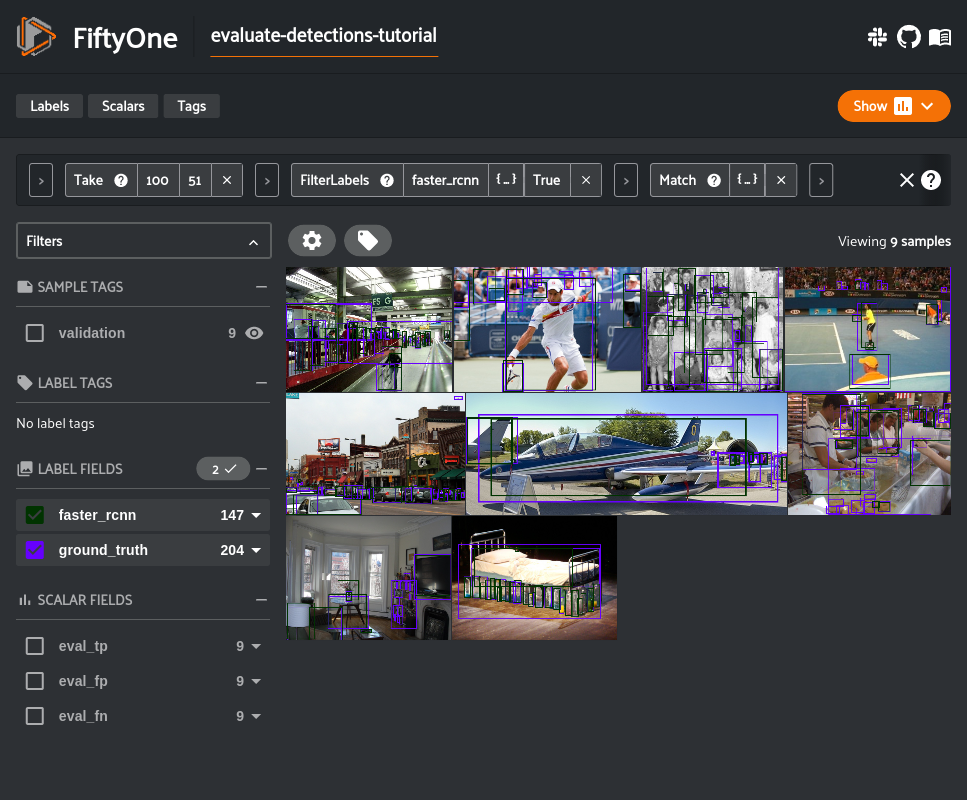

In [ ]:
# Create a view that contains only samples for which at least one detection has 
# its iscrowd attribute set to 1
crowded_images_view = high_conf_view.match(
    F("ground_truth.detections").filter(F("attributes.iscrowd.value") == 1).length() > 0
)

session.view = crowded_images_view

### Duplicate detections

In [ ]:
# Look at the TP, FP, FN detection based on bbox size
# session.view = small_boxes_eval_view
# session.view = medium_boxes_eval_view
# session.view = large_boxes_eval_view
# session.show()

Following analysis only possible disney_3D_human_test annotations (i.e., duplicate_detection, false_positive, etc):

In [ ]:
# Look at duplicate detections
dd_view = high_conf_view.filter_labels("predictions", F("duplicate_detection") == 'true')

# dd_view = small_boxes_eval_view.filter_labels("predictions", F("duplicate_detection") == 'true')
# dd_view = medium_boxes_eval_view.filter_labels("predictions", F("duplicate_detection") == 'true')
# dd_view = large_boxes_eval_view.filter_labels("predictions", F("duplicate_detection") == 'true')

session.view = dd_view
#session.show()

In [ ]:
# How many FPs were actually DDs upon manual inspection?
fp_dd = dd_view.filter_labels("predictions", F("eval_oi")=="fp")
session.view = fp_dd
session.show()

In [ ]:
# Can't control for it being the same face, so overestimates errors
# How many FN detections were actually TPs upon manual inspection due to FP prediction (bbox too large or duplicate detection)?
fn_view = high_conf_view.filter_labels("detections", F("eval_oi")=="fn")
# To see # FNs
#session.view = fn_view
#session.show()
# To estimate # FNs that were TPs
fn_fp = fn_view.filter_labels("predictions", (F("false_positive")=="false") & (F("eval_oi")=="fp"))
session.view = fn_fp
session.show()

### More complex insights

Let's combine our previous operations to form more complex queries that provide deeper insight into the quality of our detections.

For example, let's sort our view of crowded images from the previous section in decreasing order of false positive counts, so that we can see samples that have many (allegedly) spurious predictions in images that are known to contain crowds of objects:


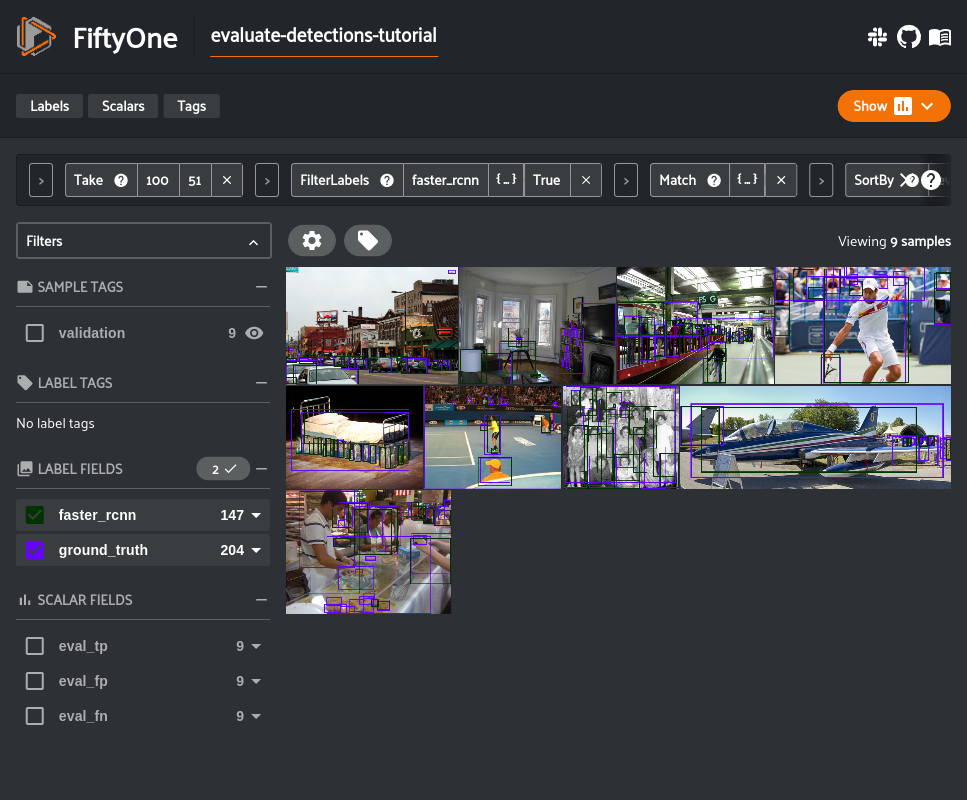

In [ ]:
session.view = crowded_images_view.sort_by("eval_fp", reverse=True)

Let's compare the above view to another view that just sorts by false positive count, regardless of whether the image is crowded:

In [ ]:
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

Finally let's open an expanded view of the sample with the most false positive predictions to investigate in more detail:

In [ ]:
session.show()

**See anything interesting?**

What you find will likely be different because a random subset of samples were chosen. In our case, we find missing ground truth boxes for two of the laptop keyboards, a bottle, and even perhaps a cell phone. The model did not confidently predict many of the boxes in this image, but from a high-level, an example like this makes us consider the consequences of including complex or dense images in datasets. It will likely mean incorrect or incomplete ground truth annotations the annotators are not diligent! And that ultimately leads to confused models, and misinformed evaluations.

This conclusion would have been nearly impossible to achieve without visually inspecting the individual samples in the dataset according to the variety of criteria that we considered in this tutorial.

In [ ]:
session.freeze()  # screenshot the active App for sharing

### Tagging and next steps

In practice, the next step is to take action on the issues that we identified above. A natural first step is to *tag* the issues so they can be retrieved and dealt with later. FiftyOne provides support for [tagging samples and labels](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), both programmatically and via the App.

In your App instance, try tagging the predictions with missing ground truth detections. You can do this by clicking on the boxes of the predictions of interest and using the tagging element in the top-right corner to assign a `possibly-missing` tag.

Alternatively, we can programmatically tag a batch of labels by creating a view that contains the objects of interest and then applying [tag_labels()](https://voxel51.com/docs/fiftyone/user_guide/fiftyone.core.collections.html?highlight=tag_labels#fiftyone.core.collections.SampleCollection.tag_labels):

In [ ]:
# Tag all highly confident false positives as "possibly-missing"
(
    high_conf_view
        .filter_labels("faster_rcnn", F("eval") == "fp")
        .select_fields("faster_rcnn")
        .tag_labels("possibly-missing")
)

These tagged labels could then be sent off to our annotation provider of choice for review and addition to the ground truth labels. FiftyOne currently offers integrations for [Scale AI](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html), [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html), and [CVAT](https://voxel51.com/docs/fiftyone/api/fiftyone.types.dataset_types.html?highlight=cvat#fiftyone.types.dataset_types.CVATImageDataset).

For example, the snippet below exports the tagged labels and their source media to disk in CVAT format:

In [ ]:
# Export all labels with the `possibly-missing` tag in CVAT format
(
    dataset
        .select_labels(tags=["possibly-missing"])
        .export("/path/for/export", fo.types.CVATImageDataset)
)

## Intersection of predicted bboxes

In [ ]:
# Predictions dictionary
# print(predictions)
print(len(predictions))

818


In [ ]:
#import pandas as pd
#df = pd.DataFrame.from_dict(detections)
#df

In [ ]:
# Get image ids
ids = [x["image_id"] for x in predictions]
unique_ids = list(set(ids))
# unique_ids

In [ ]:
def get_matches(id, predictions):
  matches = [x for x in predictions if x["image_id"] == id]
  return matches

In [ ]:
def lowest_conf_pred(pair):
  if pair[1]["score"] <= pair[0]["score"]:
    return pair[1]["id"]
  else:
    return pair[0]["id"]

In [ ]:
def check_intersection(pairs):
  # Store prediction ids that are duplicate detections in image
  preds_to_remove = []

  for pair in pairs:
    #print(pair)

    # Calculate intersection overlap
    # Bounding box format is [top-left-x, top-left-y, width, height]
    a_x1 = pair[0]["bbox"][0]
    a_y1 = pair[0]["bbox"][1]
    a_x2 = pair[0]["bbox"][0] + pair[0]["bbox"][2]
    a_y2 = pair[0]["bbox"][1] + pair[0]["bbox"][3]

    b_x1 = pair[1]["bbox"][0]
    b_y1 = pair[1]["bbox"][1]
    b_x2 = pair[1]["bbox"][0] + pair[1]["bbox"][2]
    b_y2 = pair[1]["bbox"][1] + pair[1]["bbox"][3]

    dx = min(a_x2, b_x2) - max(a_x1, b_x1)
    dy = min(a_y2, b_y2) - max(a_y1, b_y1)
    if (dx>=0) and (dy>=0):
      intersection = dx*dy
      #print(f"Intersection area: {intersection}")

      # Is the intersection greater than 50% of eitehr bbox area?
      a_overlap = intersection / pair[0]["area"]
      b_overlap = intersection / pair[1]["area"]
      #print(f"Overlap percentage: {a_overlap}, {b_overlap}")
      if a_overlap >= 0.5 or b_overlap >= 0.5:
        id = lowest_conf_pred(pair)
        preds_to_remove.append(id)
        #print(f"Id to remove: {id}")
    else:
      #print("No intersection")
      continue
    
  return(preds_to_remove)

In [ ]:
import itertools
complete_list = []

for id in unique_ids:
  # Get all predictions from 1 image
  matches = get_matches(id, predictions)

  # Sort the boxes from highest to lowest conf score
  matches.sort(key=lambda x: x["score"], reverse=True)
  #print(matches)

  # Create list with all unique pair-wise permutations
  pair_order_list = itertools.combinations(matches,2)
  pairs = list(pair_order_list)
  num_pairs = len(pairs)
  #print(num_pairs)

  # Skip if only one prediction in image
  if num_pairs == 0:
    #print(f"Skipping id: {id}")
    continue

  # Get predictions ids that are duplicate detections
  preds_to_remove = check_intersection(pairs)
  if len(preds_to_remove) > 0:
    # Add ids to remove
    complete_list.extend(preds_to_remove)

unique_complete_list = list(set(complete_list))
# print(unique_complete_list)
print(len(unique_complete_list))

In [ ]:
new_predictions = []
for x in predictions:
  if x["id"] not in unique_complete_list:
    new_predictions.append(x)

len(new_predictions)

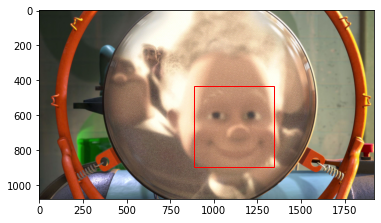

In [ ]:
# # Handy for checking x1, y1, w, h/ x2, y2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from PIL import Image

# im = Image.open('/content/disney_3D_human_test/meet-the-robinsons-disneyscreencaps.com-9997.jpg')

# # Create figure and axes
# fig, ax = plt.subplots()

# # Display the image
# ax.imshow(im)

# # Create a Rectangle patch
# # [887.0, 432.0, 458.0, 463.0]
# rect = patches.Rectangle((887.0, 432.0), 458.0, 463.0, linewidth=1, edgecolor='r', facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)

# plt.show()

## Crop Detected Faces

In [ ]:
# Detectron2
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pyyaml==5.1  > /dev/null
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [ ]:
import os
import cv2
import json
from PIL import Image

import detectron2
from detectron2.utils.logger import setup_logger
import detectron2.data
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
preds_file = "/content/out/coco_instances_results.json"
gt_file = "/content/out/Detection_Test_coco_format.json"
gt_file_instances = "Detection_Test/instances.json"

In [ ]:
# Folder to save cropped out predictions to
!mkdir Detection_Test_Inference_Portraits
dst_path = "/content/Detection_Test_Inference_Portraits"

In [ ]:
# Load GT and preds
DATASET_TARGET = ""
gt_dic = detectron2.data.datasets.load_coco_json(f"{gt_file}", 
                                                  DATASET_TARGET, 
                                                  #"disney",
                                                  #extra_annotation_keys=["attributes"]
                                                  )
json_file = f"{gt_file_instances}"
with open(json_file) as f:
    gt_dic_instances = json.load(f)

json_file = f"{preds_file}"
with open(json_file) as f:
    pred_dic = json.load(f)

[09/06 17:37:03 d2.data.datasets.coco]: Loaded 650 images in COCO format from /content/out/Detection_Test_coco_format.json


In [ ]:
print(f"GTs: {len(gt_dic)}, Pred: {len(pred_dic)}")
print(gt_dic[0])
print(gt_dic_instances[0])
print(pred_dic[0])

GTs: 650, Pred: 6359
{'file_name': './Detection_Test/aristocats-disneyscreencaps.com-3766.jpg', 'height': 1080, 'width': 1808, 'image_id': 'cl5hx7i48q0gz0fzw8deyhcfw', 'annotations': [{'iscrowd': 0, 'bbox': [631.0, 436.0, 440.0, 383.0], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': 'datasets/Detection_Test/aristocats-disneyscreencaps.com-3766.jpg', 'height': 1080, 'width': 1808, 'image_id': 1, 'annotations': [{'iscrowd': 0, 'bbox': [631, 436, 440, 383], 'category_id': 0, 'attributes': {'animation_style': '2_d', 'character_style': 'animal', 'gender': 'male'}, 'bbox_mode': 1}]}
{'image_id': 'cl5hx7i48q0gz0fzw8deyhcfw', 'category_id': 0, 'bbox': [678.6345825195312, 470.31805419921875, 305.26812744140625, 348.96771240234375], 'score': 0.9956839084625244}


In [ ]:
# Add filepath to each prediction
pred_dic_70 = []
for pred in pred_dic:
  if pred["score"] >= 0.7: # high conf
    id = pred["image_id"]
    for gt in gt_dic:
      if id == gt["image_id"]:
        pred["file_name"] = gt["file_name"]
        break
    pred_dic_70.append(pred)

print(pred_dic_70[0])

{'image_id': 'cl5hx7i48q0gz0fzw8deyhcfw', 'category_id': 0, 'bbox': [678.6345825195312, 470.31805419921875, 305.26812744140625, 348.96771240234375], 'score': 0.9956839084625244, 'file_name': './Detection_Test/aristocats-disneyscreencaps.com-3766.jpg'}


In [ ]:
# Add animation_style to each prediction
for pred in pred_dic_70:
  fname = pred["file_name"].split("/")[-1]
  for gt in gt_dic_instances:
    if fname == gt["file_name"].split("/")[-1]:
      pred["animation_style"] = gt["annotations"][0]["attributes"]["animation_style"]
      break

print(pred_dic_70[0])

{'image_id': 'cl5hx7i48q0gz0fzw8deyhcfw', 'category_id': 0, 'bbox': [678.6345825195312, 470.31805419921875, 305.26812744140625, 348.96771240234375], 'score': 0.9956839084625244, 'file_name': './Detection_Test/aristocats-disneyscreencaps.com-3766.jpg', 'animation_style': '2_d'}


In [ ]:
print(f"GTs: {len(gt_dic)}, Pred: {len(pred_dic_70)}")
print(pred_dic_70[0])

GTs: 650, Pred: 1510
{'image_id': 'cl5hx7i48q0gz0fzw8deyhcfw', 'category_id': 0, 'bbox': [678.6345825195312, 470.31805419921875, 305.26812744140625, 348.96771240234375], 'score': 0.9956839084625244, 'file_name': './Detection_Test/aristocats-disneyscreencaps.com-3766.jpg', 'animation_style': '2_d'}


In [ ]:
# Save edited dic to new file
f = open(f"{dst_path}/high_conf_predictions.json","w")
f.write(json.dumps(pred_dic_70))
f.close()

In [ ]:
# Crop predictions
dst_path = "/content/Detection_Test_Inference_Portraits"
counter = 0
for pred in pred_dic_70:
  fpath = pred["file_name"]
  fname = fpath.split("/")[-1]
  name = fname.split(".jpg")[0]
  img = cv2.imread(fpath)
  x1, y1, w, h = pred["bbox"]
  crop_img = img[int(y1):int(y1+h), int(x1):int(x1+w)]
  cv2.imwrite(f"{dst_path}/{name}-{counter}.jpg", crop_img)
  counter += 1

In [ ]:
import os
len(os.listdir(dst_path)), len(pred_dic_70)

(1511, 1510)

In [ ]:
# Save to Drive
!zip -r /content/drive/MyDrive/machine_learning/Analysis/Classification_Train_Test/Detection_Test_Inference_Portraits.zip Detection_Test_Inference_Portraits > /dev/null